In [1]:
import cv2
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from sklearn.metrics import precision_recall_fscore_support



In [2]:
class HarmfulObjectDataset(Dataset):
    def __init__(self, imgs_path, labels_path, transforms=None):
        self.imgs_path = imgs_path
        self.labels_path = labels_path
        self.transforms = transforms
        
        self.img_names = [img for img in sorted(os.listdir(self.imgs_path)) if img.endswith(('.jpg', '.png', '.jpeg'))]
        self.label_names = [label for label in sorted(os.listdir(self.labels_path)) if label.endswith('.txt')]
        
        self.img_names = [img for img in self.img_names if self._get_label_file(img)]

    def _get_label_file(self, img_name):
        base_name = img_name.rsplit('.', 1)[0]
        label_file = f"{base_name}.txt"
        return label_file if label_file in self.label_names else None

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.imgs_path, img_name)
        label_file = self._get_label_file(img_name)
        label_path = os.path.join(self.labels_path, label_file)
        
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_rgb /= 255.0
        
        if self.transforms:
            img_rgb = self.transforms(img_rgb)
        
        with open(label_path, 'r') as f:
            line = f.readline().strip().split()
            label = int(line[0])
            x_center, y_center, width, height = map(float, line[1:])
        
        img_height, img_width = img_rgb.shape[1], img_rgb.shape[2]
        x_min = (x_center - width / 2) * img_width
        y_min = (y_center - height / 2) * img_height
        x_max = (x_center + width / 2) * img_width
        y_max = (y_center + height / 2) * img_height

        # Ensure boxes have positive width and height
        if x_min >= x_max or y_min >= y_max:
            raise ValueError(f"Invalid bounding box: ({x_min}, {y_min}, {x_max}, {y_max})")
        
        boxes = torch.as_tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32)
        labels = torch.as_tensor([label], dtype=torch.int64)
        
        target = {"boxes": boxes, "labels": labels}
        
        return img_rgb, target


In [3]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


def make_predictions(model, image, device):
    model.eval()
    with torch.no_grad():
        prediction = model(image)
    return prediction[0]


def calculate_iou(pred_box, gt_box):
    # Calculate intersection
    x_min = max(pred_box[0], gt_box[0])
    y_min = max(pred_box[1], gt_box[1])
    x_max = min(pred_box[2], gt_box[2])
    y_max = min(pred_box[3], gt_box[3])
    
    intersection_area = max(0, x_max - x_min) * max(0, y_max - y_min)
    
    # Calculate union
    pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    
    union_area = pred_box_area + gt_box_area - intersection_area
    
    iou = intersection_area / union_area
    return iou



In [4]:
def evaluate_model(model, data_loader, iou_threshold=0.5):
    model.eval()
    device = torch.device("cpu")  # Assuming you're running on CPU
    
    all_labels = []
    all_predictions = []
    
    ious = []
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            predictions = model(images)

            for i, prediction in enumerate(predictions):
                boxes_pred = prediction['boxes'].cpu().numpy()
                labels_pred = prediction['labels'].cpu().numpy()
                
                boxes_gt = targets[i]['boxes'].cpu().numpy()
                labels_gt = targets[i]['labels'].cpu().numpy()
                
                for pred_box, gt_box in zip(boxes_pred, boxes_gt):
                    iou = calculate_iou(pred_box, gt_box)
                    ious.append(iou)
                    
                    if iou >= iou_threshold:
                        all_predictions.append(1)  # True positive
                        all_labels.append(1)
                    else:
                        all_predictions.append(0)  # False positive or negative
                        all_labels.append(1)
                
                precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
                
                precision_list.append(precision)
                recall_list.append(recall)
                f1_list.append(f1)
                
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    avg_f1 = sum(f1_list) / len(f1_list)
    
    print(f"Average Precision: {avg_precision}")
    print(f"Average Recall: {avg_recall}")
    print(f"Average F1 Score: {avg_f1}")

    return avg_precision, avg_recall, avg_f1, ious



In [5]:
def plot_metrics(avg_precision, avg_recall, avg_f1, ious):
    # Bar plot for Precision, Recall, F1-Score
    metrics = ['Precision', 'Recall', 'F1-Score']
    scores = [avg_precision, avg_recall, avg_f1]

    plt.figure(figsize=(10, 5))
    plt.bar(metrics, scores, color=['blue', 'green', 'red'])
    plt.title('Precision, Recall, and F1 Score')
    plt.show()

    # Plotting IoU values
    plt.hist(ious, bins=50, range=(0, 1), color='blue', alpha=0.7)
    plt.title('IoU Distribution')
    plt.xlabel('IoU')
    plt.ylabel('Frequency')
    plt.show()

In [6]:
def main(image_path, model_path):
    device = torch.device("cpu")  # Set to CPU explicitly

    # Load model
    num_classes = 5  # Change according to your number of classes
    model = get_model(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load model on CPU
    model.to(device)

    # Prepare dataset and data loader
    transforms = T.Compose([T.ToTensor()])
    dataset = HarmfulObjectDataset(imgs_path='/kaggle/input/harmful-object-detection/Harmful Object Detection/Images', labels_path='/kaggle/input/harmful-object-detection/Harmful Object Detection/Labels', transforms=transforms)
    data_loader = DataLoader(dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    # Evaluate model
    avg_precision, avg_recall, avg_f1, ious = evaluate_model(model, data_loader)

    # Plot results
    plot_metrics(avg_precision, avg_recall, avg_f1, ious)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 179MB/s]
/tmp/ipykernel_17/1012857814.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value)

Average Precision: 0.9994694960212201
Average Recall: 0.9088273299528926
Average F1 Score: 0.9513982649755731


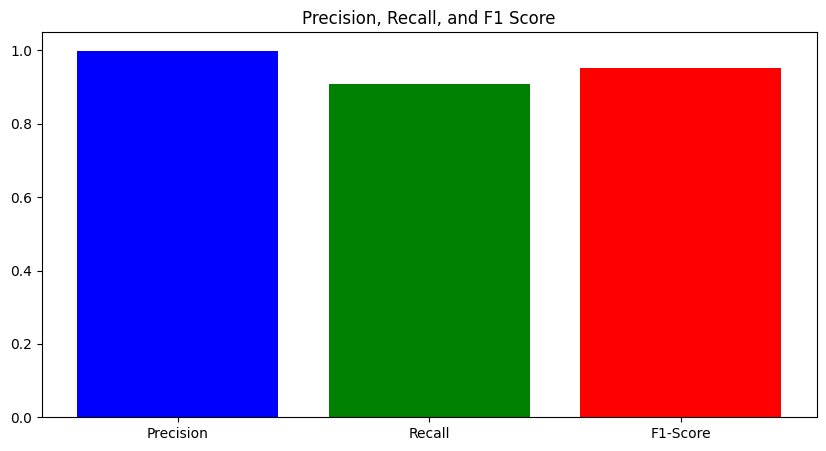

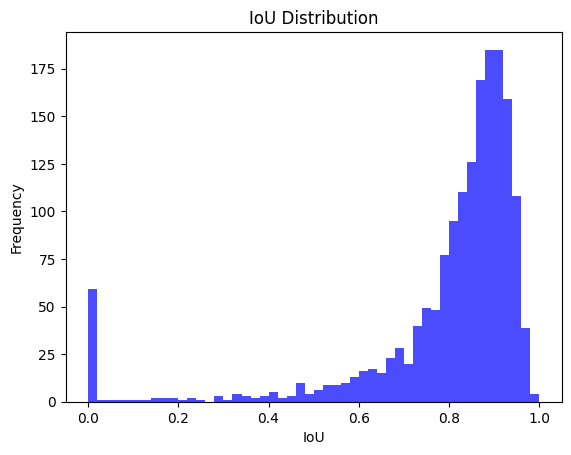

In [7]:
if __name__ == "__main__":
    # Specify the path to your image and the trained model
    image_path = '/kaggle/input/harmful-object-detection/Harmful Object Detection/Images/image 12.jpeg'  # Change this to your image path
    model_path = '/kaggle/input/hod-new-model/harmful_object_detector.pth'  # Path to your trained model

    main(image_path, model_path)